In [2]:
import json, nltk, pandas as pd, numpy as np, pickle
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import neattext.functions as nfx

DAILYDIALOG_DIR_PATH = "../data/dailydialog/"

In [3]:
def preprocess_text(text:str)->str:
    text = text.lower()
    text = nfx.remove_punctuations(text)
    text = nfx.remove_stopwords(text)
    text = ' '.join(text.split())

    return text

In [4]:
def create_utterances(filename:str, split: str):
    sentences, act_labels, emotion_labels, speakers, conv_id, utt_id = [], [], [], [], [], []

    with open(filename, 'r') as f:
        for c_id, line in enumerate(f):
            s = eval(line)
            for u_id, item in enumerate(s['dialogue']):
                sentences.append(item['text'])
                act_labels.append(item['act'])
                emotion_labels.append(item['emotion'])
                conv_id.append(split[:2] + "_c" + str(c_id))
                utt_id.append(split[:2] + "_c" + str(c_id) + "_u" + str(u_id))
                speakers.append(str(u_id%2))

    data = pd.DataFrame(sentences, columns=['sentence'])
    data['sentence'] = data['sentence'].apply(lambda x: preprocess_text(x))
    data['act_label'] = act_labels
    data['emotion_label'] = emotion_labels
    data['speaker'] = speakers
    data['conv_id'] = conv_id
    data['utt_id'] = utt_id

    return data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emotion_value_counts(data, partition, column='emotion_label'):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=column, data=data)
    ax.bar_label(ax.containers[0])
    plt.title(f"Value counts for emotions ({partition} set)")
    plt.show()

In [6]:
def load_pretrained_glove():
    print("Loading GloVe mdoel...")
    glv_vector = {}
    f = open("../glove_model/glove.6B.100d.txt", encoding="utf-8")

    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue

    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

In [7]:
def encode_labels(encoder, l):
    return encoder[l]

In [8]:
from collections import Counter

def extract_keywords(text:str, num:int = 50)->dict:
    tokens = [token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [9]:
def plot_keywords(keywords_dict: dict, emotion:str):
    keyword_df = pd.DataFrame(keywords_dict.items(), columns=['token', 'count'])
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x='token', y='count', data=keyword_df)
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=45)
    plt.title("Keyword counts for " + emotion)
    plt.show()

In [10]:
# Generate datasets
train_data = create_utterances(DAILYDIALOG_DIR_PATH + 'train.json', 'train')
valid_data = create_utterances(DAILYDIALOG_DIR_PATH + 'valid.json', 'valid')
test_data = create_utterances(DAILYDIALOG_DIR_PATH + 'test.json', 'test')

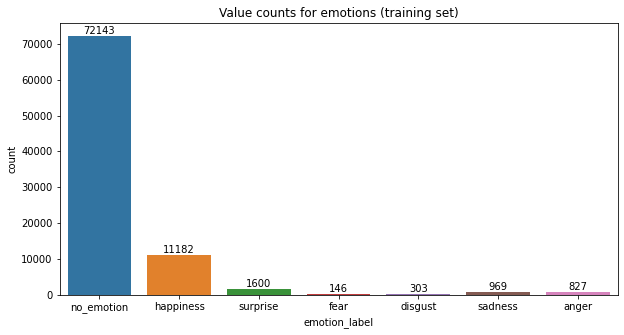

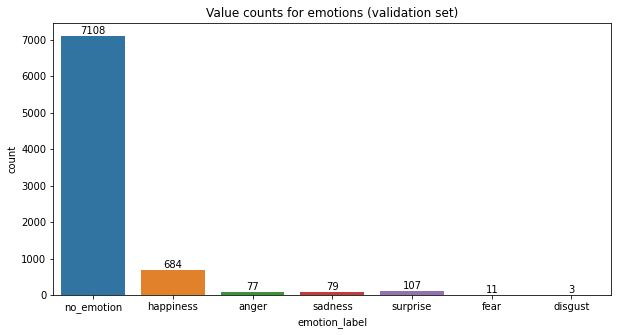

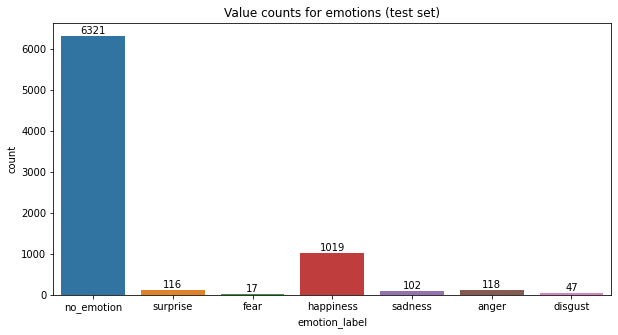

In [11]:
# Plot emotion value counts
plot_emotion_value_counts(train_data, 'training')
plot_emotion_value_counts(valid_data, 'validation')
plot_emotion_value_counts(test_data, 'test')

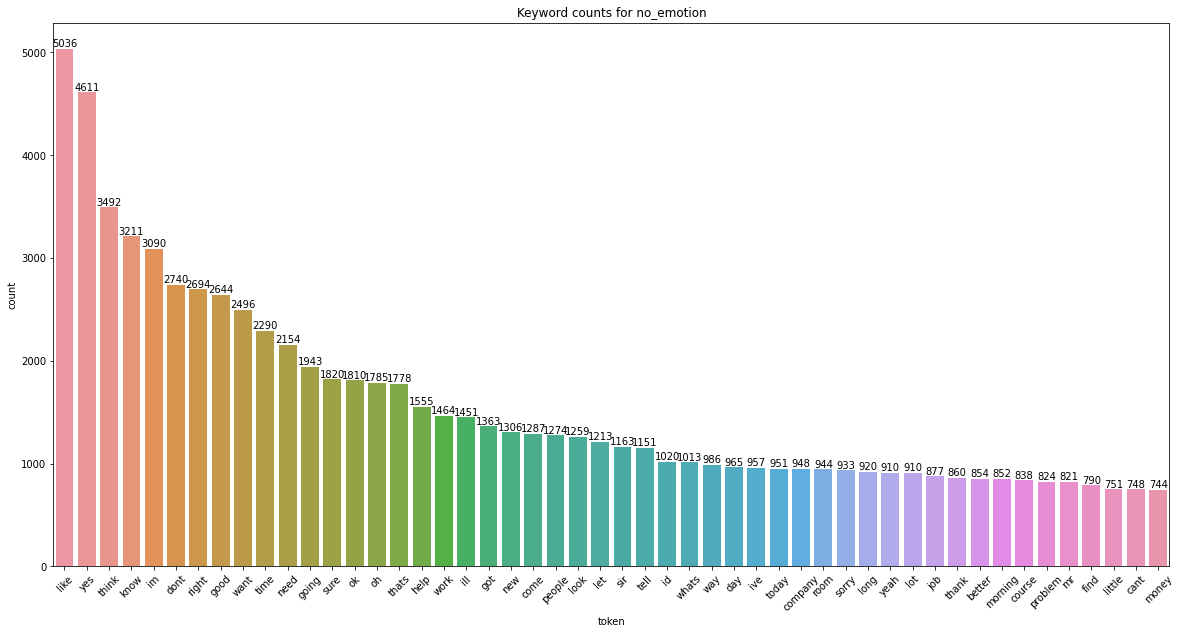

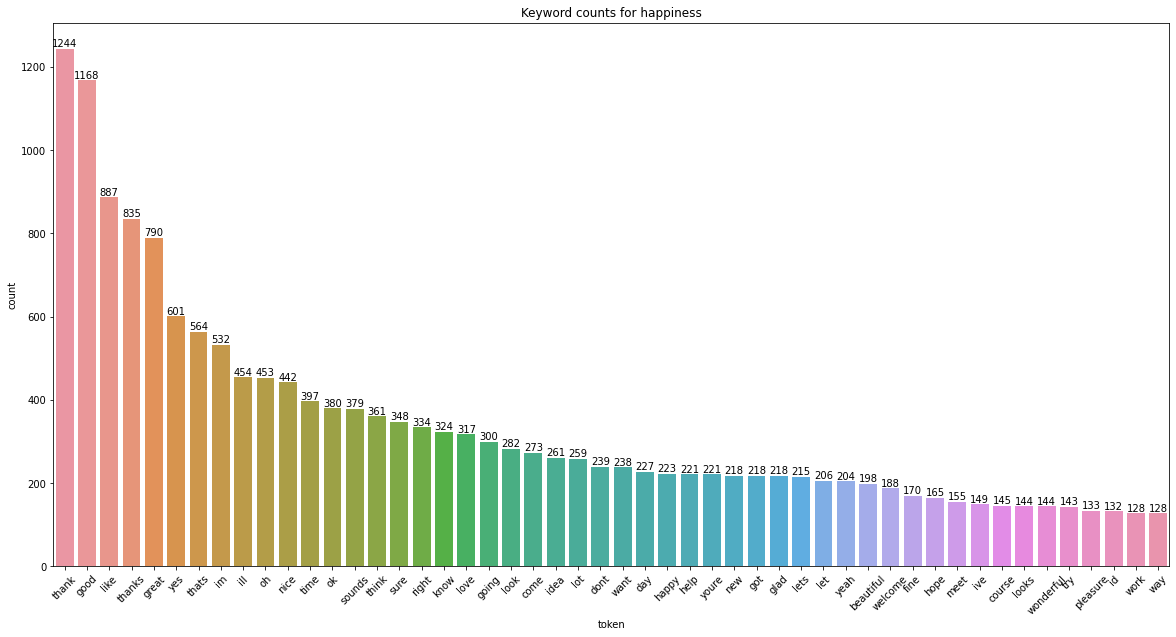

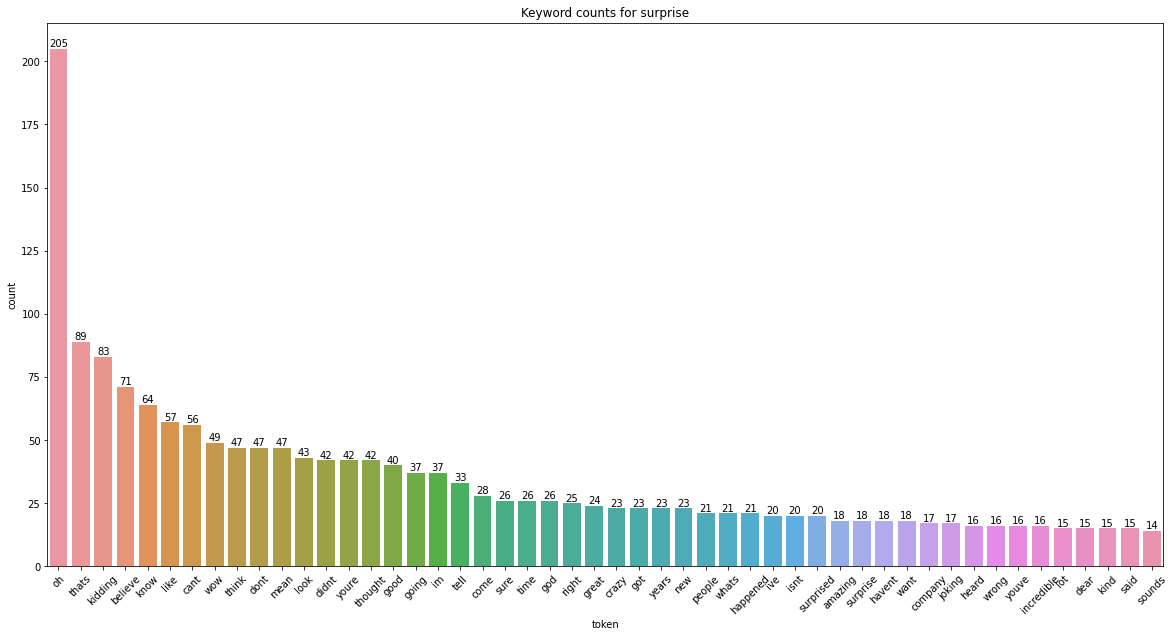

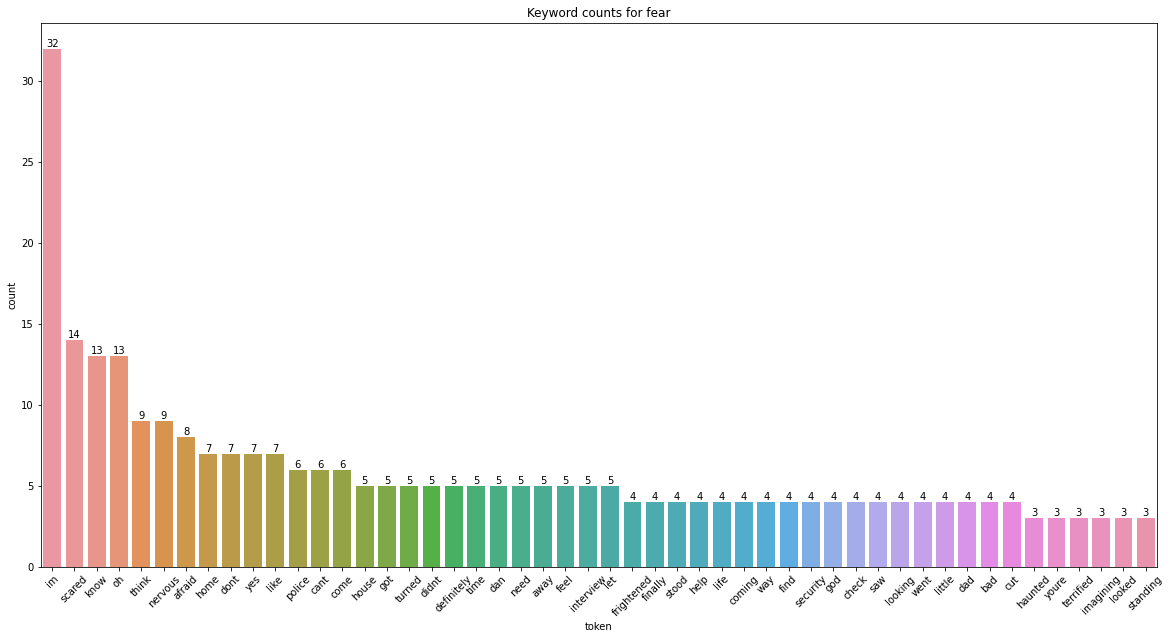

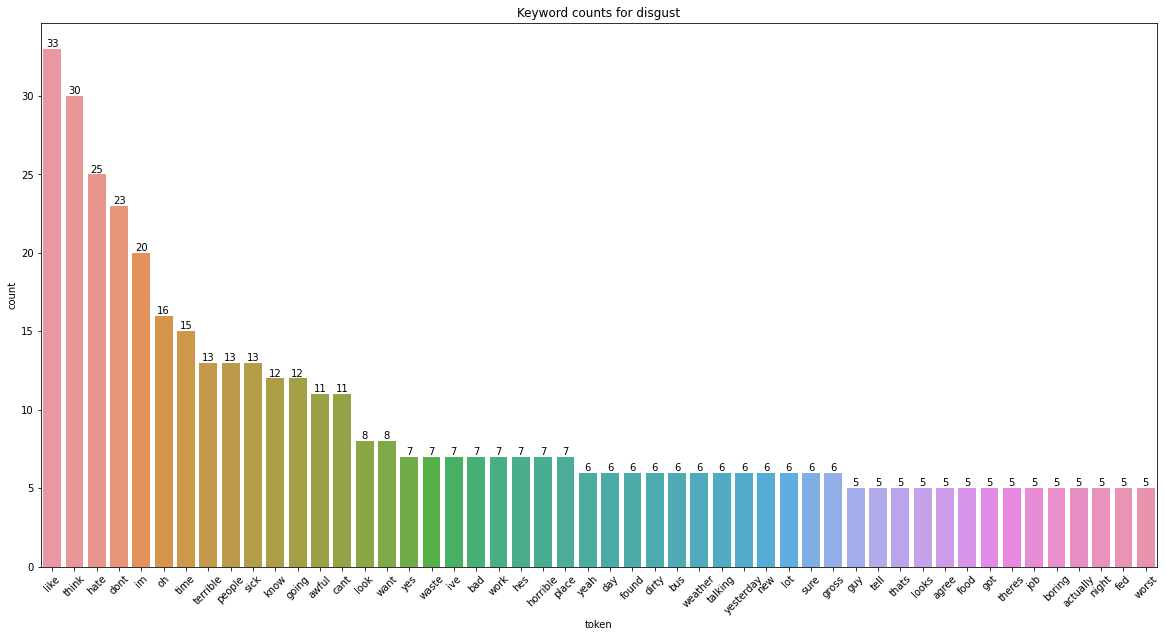

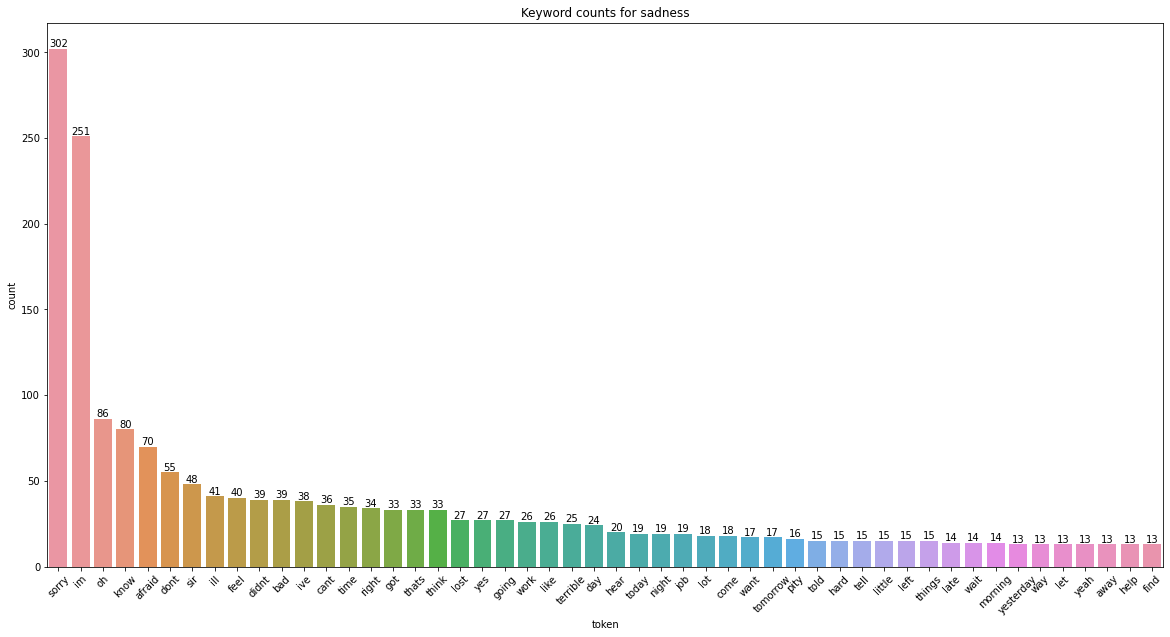

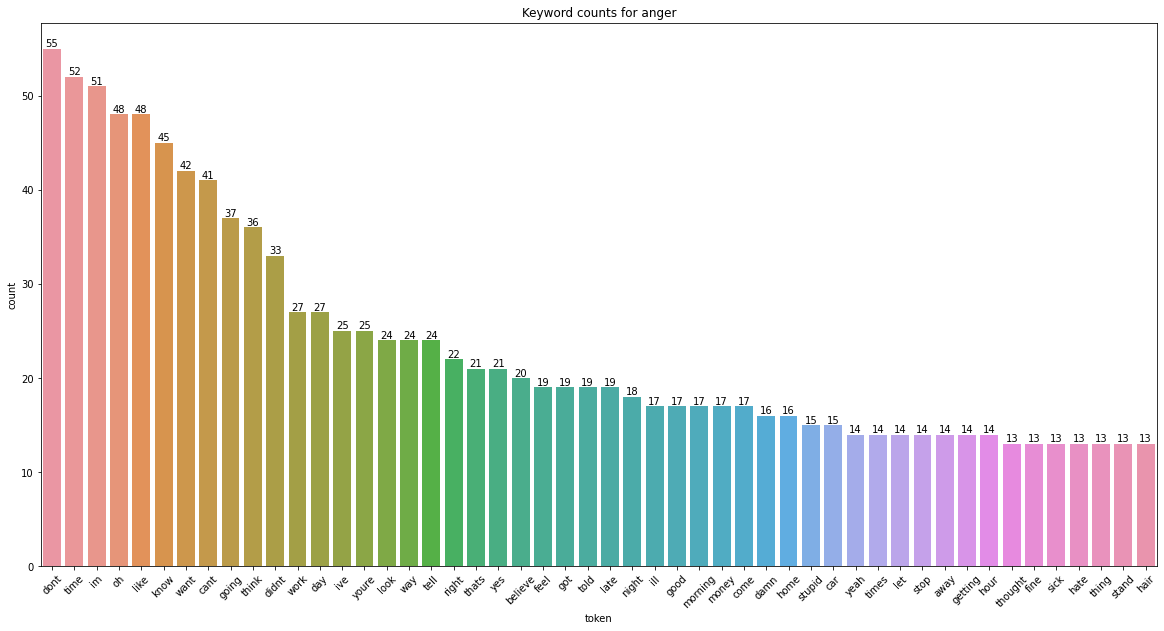

In [12]:
# Get keywords for each emotion
emotion_list = list(train_data["emotion_label"].unique())

for emotion in emotion_list:
    text_list = train_data[train_data["emotion_label"] == emotion]["sentence"].tolist()
    word_doc = ' '.join(text_list)
    keywords = extract_keywords(word_doc)
    plot_keywords(keywords, emotion)

In [13]:
# Encode emotion and dialog act labels
all_act_labels, all_emotion_labels = set(train_data["act_label"]), set(train_data["emotion_label"])
act_label_encoder, emotion_label_encoder, act_label_decoder, emotion_label_decoder = {}, {}, {}, {}

for i, label in enumerate(all_act_labels):
    act_label_encoder[label] = i
    act_label_decoder[i] = label

for i, label in enumerate(all_emotion_labels):
    emotion_label_encoder[label] = i
    emotion_label_decoder[i] = {}

pickle.dump(act_label_encoder, open(DAILYDIALOG_DIR_PATH + "act_label_encoder.pkl", "wb"))
pickle.dump(act_label_decoder, open(DAILYDIALOG_DIR_PATH + "act_label_decoder.pkl", "wb"))
pickle.dump(emotion_label_encoder, open(DAILYDIALOG_DIR_PATH + "emotion_label_encoder.pkl", "wb"))
pickle.dump(emotion_label_decoder, open(DAILYDIALOG_DIR_PATH + "emotion_label_decoder.pkl", "wb"))

train_data['encoded_act_label'] = train_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))
test_data['encoded_act_label'] = test_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))
valid_data['encoded_act_label'] = valid_data['act_label'].map(lambda x: encode_labels(act_label_encoder, x))

train_data['encoded_emotion_label'] = train_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
test_data['encoded_emotion_label'] = test_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
valid_data['encoded_emotion_label'] = valid_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))

In [14]:
# Tokenize all sentences
all_text = list(train_data['sentence'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
pickle.dump(tokenizer, open(DAILYDIALOG_DIR_PATH + "tokenizer.pkl", "wb"))

In [15]:
# Convert sentences into sequences
train_sequence = tokenizer.texts_to_sequences(list(train_data['sentence']))
valid_sequence = tokenizer.texts_to_sequences(list(valid_data['sentence']))
test_sequence = tokenizer.texts_to_sequences(list(test_data['sentence']))

train_data['sentence_length'] = [len(item) for item in train_sequence]
valid_data['sentence_length'] = [len(item) for item in valid_sequence]
test_data['sentence_length'] = [len(item) for item in test_sequence]

MAX_NUM_TOKENS = 250

train_sequence = pad_sequences(train_sequence, maxlen=MAX_NUM_TOKENS, padding='post')
valid_sequence = pad_sequences(valid_sequence, maxlen=MAX_NUM_TOKENS, padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=MAX_NUM_TOKENS, padding='post')

train_data['sequence'] = list(train_sequence)
valid_data['sequence'] = list(valid_sequence)
test_data['sequence'] = list(test_sequence)

In [16]:
# Save data in pickle format
conv_speakers = {}
conv_input_sequence = {}
conv_input_max_sequence_length = {}
conv_act_labels = {}
conv_emotion_labels = {}

print("Preparing dataset...")
train_conv_ids, test_conv_ids, valid_conv_ids = set(train_data['conv_id']), set(test_data['conv_id']), set(valid_data['conv_id'])
all_data = train_data.append(test_data, ignore_index=True).append(valid_data, ignore_index=True)

for item in list(train_conv_ids) + list(test_conv_ids) + list(valid_conv_ids):
    df = all_data[all_data['conv_id'] == item]

    conv_speakers[item] = list(df["speaker"])
    conv_input_sequence[item] = list(df["sequence"])
    conv_input_max_sequence_length[item] = max(list(df['sentence_length']))
    conv_act_labels[item] = list(df['encoded_act_label'])
    conv_emotion_labels[item] = list(df['encoded_emotion_label'])

pickle.dump([conv_speakers, conv_input_sequence, conv_input_max_sequence_length, conv_act_labels,
            conv_emotion_labels, train_conv_ids, test_conv_ids, valid_conv_ids], open(DAILYDIALOG_DIR_PATH + "daily_dialogue.pkl", "wb"))

Preparing dataset...


KeyboardInterrupt: 

In [ ]:
# Save pretrained embedding matrix
glv_vector = load_pretrained_glove()
word_vector_length = len(glv_vector['the'])
word_index = tokenizer.word_index
inv_word_index = {v: k for k, v in word_index.items()}
num_unique_words = len(word_index)
glv_embedding_matrix = np.zeros((num_unique_words + 1, word_vector_length))

for j in range(1, num_unique_words + 1):
    try:
        glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
    except KeyError:
        glv_embedding_matrix[j] = np.random.randn(word_vector_length) / 200

np.ndarray.dump(glv_embedding_matrix, open(DAILYDIALOG_DIR_PATH + "glv_embedding_matrix", "wb"))
print("Done. Completed preprocessing.")

Loading GloVe mdoel...
Completed loading pretrained GloVe model.
Done. Completed preprocessing.


In [18]:
all_data['encoded_emotion_label'].value_counts()

1    85572
3    12885
2     1823
6     1150
4     1022
5      353
0      174
Name: encoded_emotion_label, dtype: int64

In [ ]:
glv_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.68700000e-01,  8.17080000e-01,  6.98960000e-01, ...,
        -4.01100000e-01,  7.46570000e-01,  3.11220000e-01],
       [-5.01310000e-02,  6.63560000e-01,  8.43150000e-01, ...,
         1.64890000e-01,  4.87980000e-02,  5.03590000e-01],
       ...,
       [-1.68530000e-01,  1.02510000e+00, -5.81240000e-01, ...,
        -9.79440000e-01,  5.71850000e-01,  2.97990000e-02],
       [-3.91369046e-03, -2.94364827e-03, -1.20707703e-02, ...,
        -3.69735158e-05,  2.14627887e-03,  9.21837400e-03],
       [-4.44420000e-01, -4.10160000e-01, -2.69530000e-01, ...,
        -6.45760000e-01, -1.53150000e-02,  5.04850000e-01]])